In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import scipy
import copy
import math
import time

#plotting with Cartopy. 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker


# import scipy
from datetime import datetime
import os
# import utils
import importlib


# import statsmodels.api as sm
# from windspharm.xarray import VectorWind
# from windspharm.standard import VectorWind
# from windspharm.examples import example_data_path
# from windspharm.tools import prep_data, recover_data, order_latdim
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from shapely.geometry.polygon import LinearRing
from dask.diagnostics import ProgressBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import math
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import geocat.comp as gcomp
import shutil
import metpy.calc as mpcalc


In [2]:
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')

client does not exist yet


In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(project='P54048000',walltime='06:00:00')
cluster.scale(40)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/36469/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/36469/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.53:44291,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/36469/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [5]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


def wgt_rmse(fld1, fld2, wgt):
    """Calculated the area-weighted RMSE.
    Inputs are 2-d spatial fields, fld1 and fld2 with the same shape.
    They can be xarray DataArray or numpy arrays.
    Input wgt is the weight vector, expected to be 1-d, matching length of one dimension of the data.
    Returns a single float value.
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.nansum(warray * (fld1 - fld2)**2)
        return np.sqrt( wmse ).item()

#######


In [6]:
%%time 
modvers = 'f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_00_1982'

fil_out = '/glade/work/wchapman/CESM_h0_summaryfiles/' + modvers +'_h1_STOCHincs_summary.nc'
path_tofiles='/glade/scratch/wchapman/inputdata/nudging/StochAI_UV/*.nc'
remake_files = False
dovars = ['U','V']

if (os.path.exists(fil_out)) & (remake_files):
    os.remove(fil_out)

if not os.path.exists(fil_out):
    fns = sorted(glob.glob(path_tofiles))
    program_starts = time.time()

    for ee,group in enumerate(chunker(fns,100)):
        print('doing group: ',ee,' of ',len(fns)/100)
        # print(group)
        DS = xr.open_mfdataset(group,parallel=True,decode_times=False)
        print('..opened..')
        if ee == 0:
            # bbedo = DS[dovars].load()
            bbedo = DS[dovars]
        else: 
            # temp_bbedo = DS[dovars].load()
            temp_bbedo = DS[dovars]
            print('concat')
            bbedo = xr.concat([bbedo,temp_bbedo],dim='time')

        now = time.time()
        print("It has been {0} seconds since the loop started".format(now - program_starts))

    # bbedo['time']=pd.date_range(start=fns[0].split('.h0.')[-1].split('.nc')[0],end=fns[-1].split('.h0.')[-1].split('.nc')[0],freq='MS')
    # bbedo.to_netcdf(fil_out)
    
else:
    print('file existed... opening')
    bbedo = xr.open_dataset(fil_out)

doing group:  0  of  23.07
..opened..
It has been 6.194944620132446 seconds since the loop started
doing group:  1  of  23.07
..opened..
concat
It has been 8.427592754364014 seconds since the loop started
doing group:  2  of  23.07
..opened..
concat
It has been 10.510528802871704 seconds since the loop started
doing group:  3  of  23.07
..opened..
concat
It has been 12.576308727264404 seconds since the loop started
doing group:  4  of  23.07
..opened..
concat
It has been 14.67935037612915 seconds since the loop started
doing group:  5  of  23.07
..opened..
concat
It has been 17.09403157234192 seconds since the loop started
doing group:  6  of  23.07
..opened..
concat
It has been 18.966954469680786 seconds since the loop started
doing group:  7  of  23.07
..opened..
concat
It has been 21.425782918930054 seconds since the loop started
doing group:  8  of  23.07
..opened..
concat
It has been 23.42733597755432 seconds since the loop started
doing group:  9  of  23.07
..opened..
concat
It h

In [8]:
DS_DA = xr.open_mfdataset(sorted(sorted(glob.glob('/glade/scratch/wchapman/inputdata/nudging/DA_StochAI/Stochai_DA_INCS.*-12-*-*.nc'))+\
sorted(glob.glob('/glade/scratch/wchapman/inputdata/nudging/DA_StochAI/Stochai_DA_INCS.*-01-*-*.nc'))+\
sorted(glob.glob('/glade/scratch/wchapman/inputdata/nudging/DA_StochAI/Stochai_DA_INCS.*-02-*-*.nc'))),decode_times=False)
DS200_DA = DS_DA.sel(lev=200,method='nearest').load()
print('...done 1...')
DS_NU = xr.open_mfdataset(sorted(sorted(glob.glob('/glade/scratch/wchapman/inputdata/nudging/StochAI_UV/Stochai_INCS.*-12-*-*.nc'))+\
sorted(glob.glob('/glade/scratch/wchapman/inputdata/nudging/StochAI_UV/Stochai_INCS.*-01-*-*.nc'))+\
sorted(glob.glob('/glade/scratch/wchapman/inputdata/nudging/StochAI_UV/Stochai_INCS.*-02-*-*.nc'))),decode_times=False)
DS200_NU = DS_NU.sel(lev=200,method='nearest').load()

...done 1...


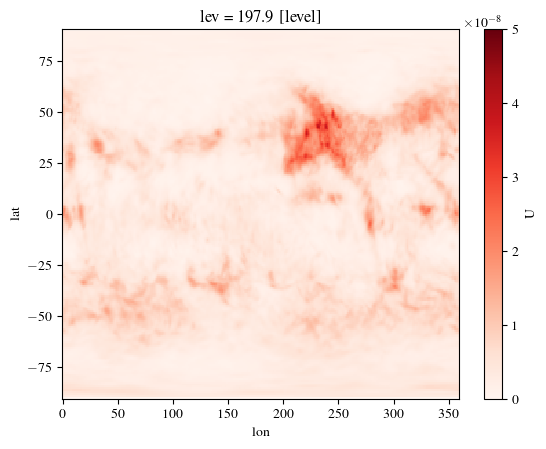

In [44]:
DS200_DA.var('time')['U'].plot(cmap='Reds',vmin=0,vmax=5e-8)
plt.show()

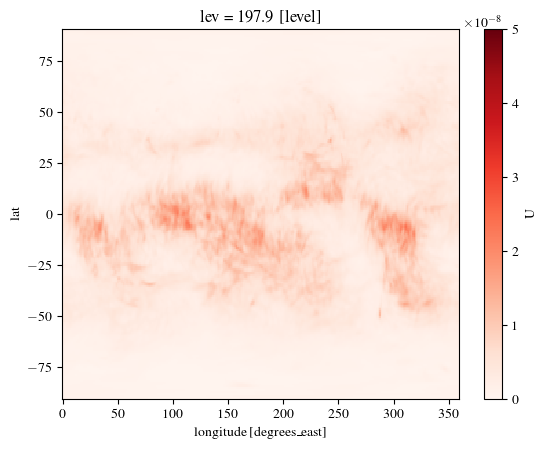

In [45]:
DS200_NU.var('time')['U'].plot(cmap='Reds',vmin=0,vmax=5e-8)
plt.show()

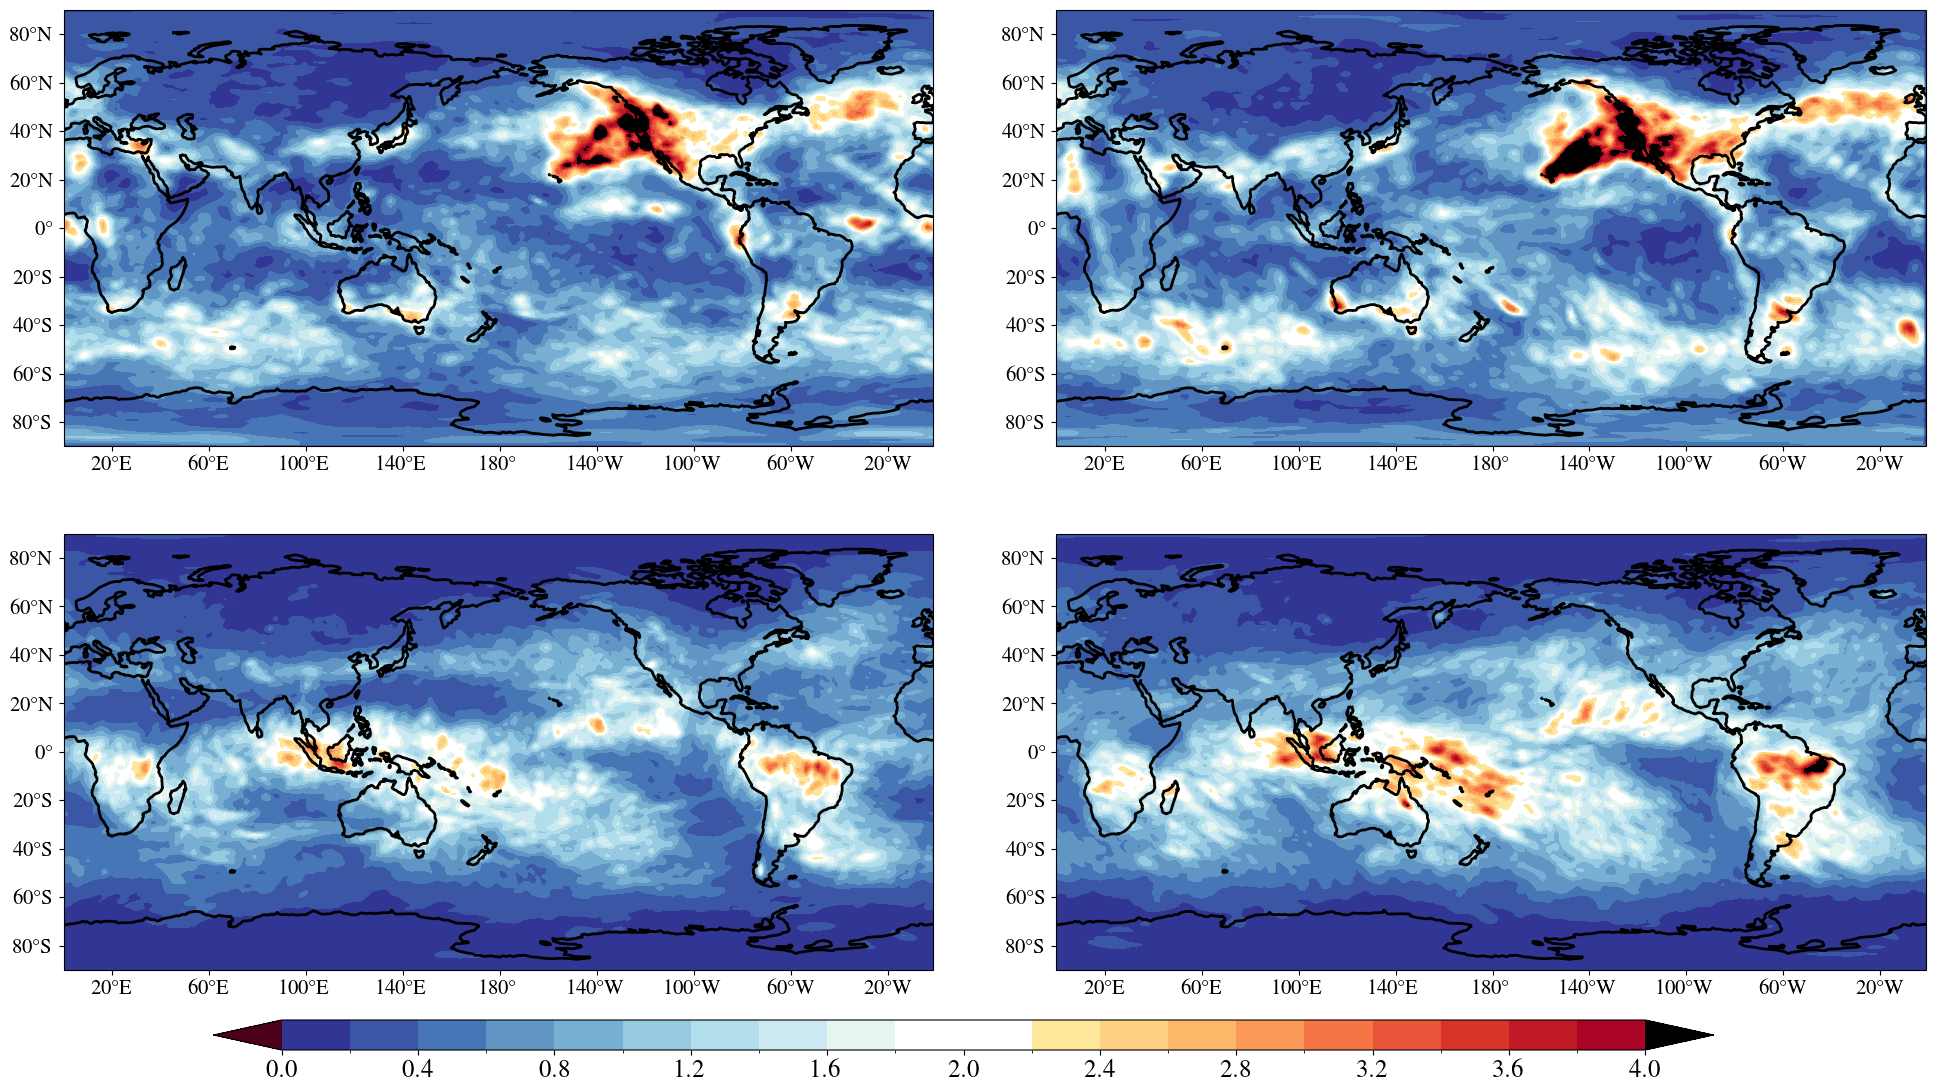

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25,20),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ax = ax.ravel()
lat = DS200_DA['lat']
lon = DS200_DA['lon']

# define the colormap
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(0)
 # make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)
for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
# define the contour levels and normalize
clevels=(np.arange(0,4.2,0.2))
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)

for nummy,ax1 in (list(enumerate(ax))):
    if nummy == 0:
        plotter_do = DS200_DA.var('time')['U']*86400*1800
    if nummy == 1:
        plotter_do = DS200_DA.var('time')['V']*86400*1800
    if nummy == 2:
        plotter_do = DS200_NU.var('time')['U']*86400*1800
    if nummy == 3:
        plotter_do = DS200_NU.var('time')['V']*86400*1800
        
    proj = ccrs.PlateCarree(central_longitude=180)
    # ax1 = plt.subplot(1, 1, 1, projection=proj)
    ax1.coastlines('110m',linewidth=2)
    cmap.set_over('k')
    cmap.set_under([0.3, 0.00, 0.1, 1.0])
    bb=ax1.contourf(lon-180,lat,plotter_do,levels=clevels,cmap=cmap,norm=norm,transform=proj,extend='both')
    # plt.contour(lon-180,lat,plotCont,levels=np.arange(100,500,50),colors='k',transform=proj)

    states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',
                        scale='10m',
                        facecolor='none')
    lat_formatter = LatitudeFormatter(number_format='.0f')
    ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.tick_params(labelsize=10) 
    ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.tick_params(labelsize=15) 
fig.subplots_adjust(bottom=.4,wspace=0.05)   
ax2 = fig.add_axes([0.2, 0.36, 0.6, 0.015])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both',orientation='horizontal', spacing='proportional')
cb.ax.tick_params(labelsize=18)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
            ## ---plotting functionality 
filepath = '/glade/work/wchapman/DA_ML/notebooks/Figures/Figure_output/'
plt.savefig(filepath +'/4Panel_Bias_increment_comparison.png', dpi=300,bbox_inches='tight')